In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
def relu(x):
    assert isinstance(x,np.ndarray),"Input to ReLU must be a numpy array"
    result=np.maximum(0,x)
    assert np.all(result>=0),"ReLU output must be non-negative"
    return result

def relu_derivative(x):
    assert isinstance(x,np.ndarray),"Input to ReLU derivative must be a numpy array"
    result=(x>0).astype(float)
    assert np.all((result==0)|(result==1)),"ReLU derivative must be 0 or 1"
    return result

def sigmoid(x):
    assert isinstance(x,np.ndarray),"Input to sigmoid must be a numpy array"
    result=1/(1+np.exp(-x))
    assert np.all((result>=0)&(result<=1)),"Sigmoid output must be in [0, 1]"
    return result

def sigmoid_derivative(x):
    assert isinstance(x,np.ndarray),"Input to sigmoid derivative must be a numpy array"
    s=sigmoid(x)
    result=s*(1-s)
    assert np.all((result>=0)&(result<=0.25)),"Sigmoid derivative must be in [0, 0.25]"
    return result

In [3]:
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.001, l2_lambda=0.0):

        """
        Initialize the neural network with given layer sizes and learning rate.
        layer_sizes: List of integers [input_size, hidden1_size, ..., output_size]
        """
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes must be a list with at least 2 elements"
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be a positive number"
        assert isinstance(l2_lambda, (int, float)) and l2_lambda >= 0, "L2 regularization strength must be a non-negative number"

        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []

        # Initialisation des poids et biais
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            assert w.shape == (layer_sizes[i], layer_sizes[i+1]), f"Weight matrix {i+1} has incorrect shape"
            assert b.shape == (1, layer_sizes[i+1]), f"Bias vector {i+1} has incorrect shape"
            self.weights.append(w)
            self.biases.append(b)

        # Paramètres pour Adam
        self.m_weights = [np.zeros_like(w) for w in self.weights]
        self.v_weights = [np.zeros_like(w) for w in self.weights]
        self.m_biases = [np.zeros_like(b) for b in self.biases]
        self.v_biases = [np.zeros_like(b) for b in self.biases]
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.t = 0
        self.l2_lambda = l2_lambda


    def forward(self, X):
        """
        Forward propagation: Z^{[l]} = A^{[l-1]} W^{[l]} + b^{[l]}, A^{[l]} = g(Z^{[l]})
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        self.activations = [X]
        self.z_values = []

        A = X
        for i in range(len(self.weights) - 1):
            z = A @ self.weights[i] + self.biases[i]
            assert z.shape == (X.shape[0], self.layer_sizes[i+1]), f"Z^{[i+1]} has incorrect shape"
            A = relu(z)
            self.z_values.append(z)
            self.activations.append(A)

        z = A @ self.weights[-1] + self.biases[-1]
        assert z.shape == (X.shape[0], self.layer_sizes[-1]), "Output Z has incorrect shape"
        output = sigmoid(z)
        assert output.shape == (X.shape[0], self.layer_sizes[-1]), "Output A has incorrect shape"
        self.z_values.append(z)
        self.activations.append(output)

        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
        assert np.all((y_true == 0) | (y_true == 1)), "y_true must contain only 0s and 1s"

        m = y_true.shape[0]
        epsilon = 1e-8
        bce_loss = -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))

        # Ajouter la régularisation L2
        l2_term = (self.l2_lambda / (2 * m)) * sum(np.sum(w ** 2) for w in self.weights)
        loss = bce_loss + l2_term

        assert not np.isnan(loss), "Loss computation resulted in NaN"
        return loss

    def compute_accuracy(self, y_true, y_pred):
        """
        Compute accuracy: proportion of correct predictions
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

        predictions = (y_pred >= 0.5).astype(int)
        accuracy = np.mean(predictions == y_true)
        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        return accuracy

    def backward(self, X, y, outputs):
        """
        Backpropagation: compute dW^{[l]}, db^{[l]} for each layer
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape == outputs.shape, "y and outputs must have the same shape"

        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]

        dZ = outputs - y
        assert dZ.shape == outputs.shape, "dZ for output layer has incorrect shape"
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m + (self.l2_lambda / m) * self.weights[-1]

        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m

        for i in range(len(self.weights) - 2, -1, -1):
            dA = dZ @ self.weights[i + 1].T
            dZ = dA * relu_derivative(self.z_values[i])
            self.d_weights[i] = (self.activations[i].T @ dZ) / m + (self.l2_lambda / m) * self.weights[i]

            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        """
        Train the neural network using mini-batch Adam optimizer, with validation
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X = X[indices]
            y = y[indices]

            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                outputs = self.forward(X_batch)
                self.backward(X_batch, y_batch, outputs)

                self.t += 1  # compteur global pour Adam

                for l in range(len(self.weights)):
                    # Adam pour les poids
                    self.m_weights[l] = self.beta1 * self.m_weights[l] + (1 - self.beta1) * self.d_weights[l]
                    self.v_weights[l] = self.beta2 * self.v_weights[l] + (1 - self.beta2) * (self.d_weights[l] ** 2)
                    m_hat_w = self.m_weights[l] / (1 - self.beta1 ** self.t)
                    v_hat_w = self.v_weights[l] / (1 - self.beta2 ** self.t)
                    self.weights[l] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)

                    # Adam pour les biais
                    self.m_biases[l] = self.beta1 * self.m_biases[l] + (1 - self.beta1) * self.d_biases[l]
                    self.v_biases[l] = self.beta2 * self.v_biases[l] + (1 - self.beta2) * (self.d_biases[l] ** 2)
                    m_hat_b = self.m_biases[l] / (1 - self.beta1 ** self.t)
                    v_hat_b = self.v_biases[l] / (1 - self.beta2 ** self.t)
                    self.biases[l] -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

            # Calculer les pertes et accuracies pour l’entraînement et la validation
            train_pred = self.forward(X)
            val_pred = self.forward(X_val)
            train_loss = self.compute_loss(y, train_pred)
            val_loss = self.compute_loss(y_val, val_pred)
            train_accuracy = self.compute_accuracy(y, train_pred)
            val_accuracy = self.compute_accuracy(y_val, val_pred)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        """
        Predict class labels (0 or 1)
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        predictions = (self.forward(X) >= 0.5).astype(int)
        assert predictions.shape == (X.shape[0], self.layer_sizes[-1]), "Predictions have incorrect shape"
        return predictions


Epoch 0, Train Loss: 0.4902, Val Loss: 0.4792, Train Acc: 0.7717, Val Acc: 0.7727
Epoch 10, Train Loss: 0.3822, Val Loss: 0.4863, Train Acc: 0.8348, Val Acc: 0.7662
Epoch 20, Train Loss: 0.3552, Val Loss: 0.5048, Train Acc: 0.8413, Val Acc: 0.7662
Epoch 30, Train Loss: 0.3273, Val Loss: 0.5286, Train Acc: 0.8565, Val Acc: 0.7662
Epoch 40, Train Loss: 0.2681, Val Loss: 0.5538, Train Acc: 0.8913, Val Acc: 0.7597
Epoch 50, Train Loss: 0.2252, Val Loss: 0.5767, Train Acc: 0.9109, Val Acc: 0.7727
Epoch 60, Train Loss: 0.3103, Val Loss: 0.6483, Train Acc: 0.8609, Val Acc: 0.7532
Epoch 70, Train Loss: 0.1550, Val Loss: 0.7006, Train Acc: 0.9587, Val Acc: 0.7468
Epoch 80, Train Loss: 0.1596, Val Loss: 0.7228, Train Acc: 0.9522, Val Acc: 0.7468
Epoch 90, Train Loss: 0.1038, Val Loss: 0.8607, Train Acc: 0.9761, Val Acc: 0.7662

Rapport de classification (Test set) :
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       100
           1       0.6

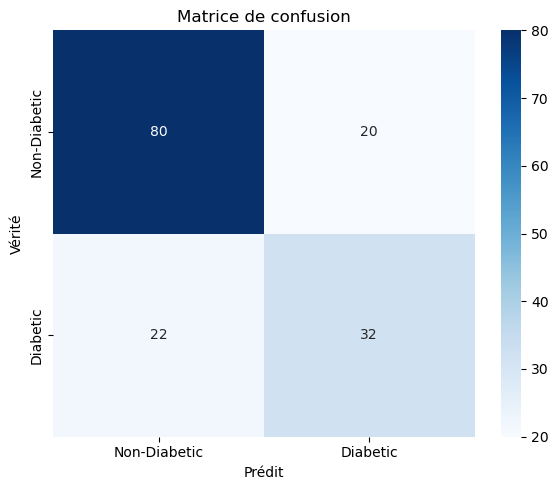

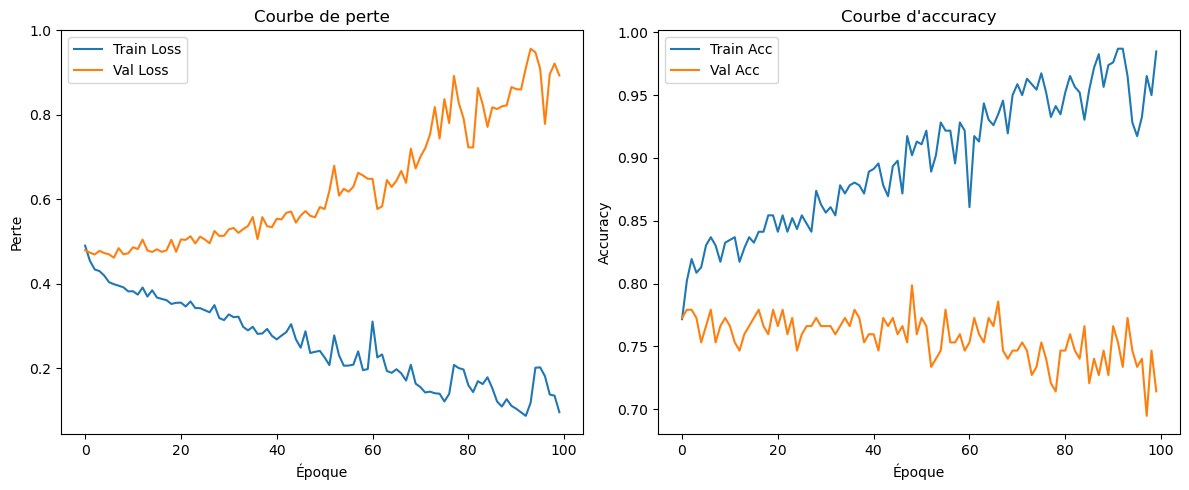

In [20]:
data=pd.read_csv('diabetes.csv')
invalid_cols=['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for col in invalid_cols:
    data[col]=data[col].replace(0,np.nan)
    data[col]=data[col].fillna(data[col].median())
X=data.drop(columns='Outcome').values
y=data['Outcome'].values.reshape(-1,1)
assert X.shape[0]==y.shape[0],"Number of samples in X and y must match"
assert X.shape[1]==8,"Expected 8 features in input data"
scaler=StandardScaler()
X=scaler.fit_transform(X)
X_temp,X_test,y_temp,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_temp,y_temp,test_size=0.25,stratify=y_temp,random_state=42)
assert X_train.shape[0]+X_val.shape[0]+X_test.shape[0]==X.shape[0],"Train-val-test split sizes must sum to total samples"
layer_sizes=[X_train.shape[1], 32, 16, 8, 1]
nn=NeuralNetwork(layer_sizes,learning_rate=0.01,l2_lambda=0.1)
train_losses,val_losses,train_accuracies,val_accuracies=nn.train(X_train,y_train,X_val,y_val,epochs=100,batch_size=32)
y_pred=nn.predict(X_test)
print("\nRapport de classification (Test set) :")
print(classification_report(y_test,y_pred))
cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=['Non-Diabetic','Diabetic'],yticklabels=['Non-Diabetic','Diabetic'])
plt.xlabel("Prédit")
plt.ylabel("Vérité")
plt.title("Matrice de confusion")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
ax1.plot(train_losses,label="Train Loss")
ax1.plot(val_losses,label="Val Loss")
ax1.set_title("Courbe de perte")
ax1.set_xlabel("Époque")
ax1.set_ylabel("Perte")
ax1.legend()
ax2.plot(train_accuracies,label="Train Acc")
ax2.plot(val_accuracies,label="Val Acc")
ax2.set_title("Courbe d'accuracy")
ax2.set_xlabel("Époque")
ax2.set_ylabel("Accuracy")
ax2.legend()
plt.tight_layout()
plt.savefig("loss_accuracy_curves.png")
plt.show()